In [1]:
from IPython.display import HTML

HTML("""<style>
.lev1 {margin-left: 80px}
.lev2 {margin-left: 100px}
.lev3 {margin-left: 120px}
.lev4 {margin-left: 140px}
.lev5 {margin-left: 160px}
.lev6 {margin-left: 180px}
</style>""")

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Build-the-network" data-toc-modified-id="Build-the-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build the network</a></div><div class="lev2 toc-item"><a href="#Loading-and-cleaning-the-full-dataset" data-toc-modified-id="Loading-and-cleaning-the-full-dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading and cleaning the full dataset</a></div><div class="lev3 toc-item"><a href="#Methodological-note" data-toc-modified-id="Methodological-note-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Methodological note</a></div><div class="lev2 toc-item"><a href="#Build-the-graph" data-toc-modified-id="Build-the-graph-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Build the graph</a></div><div class="lev2 toc-item"><a href="#Draw-the-graph" data-toc-modified-id="Draw-the-graph-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Draw the graph</a></div><div class="lev1 toc-item"><a href="#Network-statistics" data-toc-modified-id="Network-statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Network statistics</a></div><div class="lev2 toc-item"><a href="#Centralities-measures" data-toc-modified-id="Centralities-measures-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Centralities measures</a></div><div class="lev2 toc-item"><a href="#Average-degree-connectivity" data-toc-modified-id="Average-degree-connectivity-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Average degree connectivity</a></div><div class="lev2 toc-item"><a href="#Clustering-coefficient" data-toc-modified-id="Clustering-coefficient-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clustering coefficient</a></div><div class="lev2 toc-item"><a href="#Community-detection" data-toc-modified-id="Community-detection-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Community detection</a></div><div class="lev1 toc-item"><a href="#code-for-parallelization" data-toc-modified-id="code-for-parallelization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>code for parallelization</a></div><div class="lev1 toc-item"><a href="#old-code" data-toc-modified-id="old-code-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>old code</a></div>

<center>
<big><b>

Runner's Network analysis on full dataset 

</b></big>
</center>

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import powerlaw 
import networkx as nx

# Build the network 

We construct the runners' network where the _vertex are runners_ and links' weight are the __number of events the participate together__.

## Loading and cleaning the full dataset

In [7]:
full_df = pd.read_pickle('../../df_userID.pickle')
full_df.head(3)

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


### Methodological note

Even if there are few athelets that run more competition the same day, we assume we can neglet the case in which more than 1 runner does that, such that the links weights are not affected.   
With this assumption we can keep only the `RaceId`, as it's string that contraing already the _name and date_ of the race.

Removing useless features

In [8]:
full_df.drop(['MinTemp','MaxTemp','Weather',
              'LivingPlace','Rank','Category','Name',
              'Race','Date','RaceYear','RaceMonth','Place'],axis=1,inplace=True)
full_df.head(3)

,Distance,Sex,Year,Time,Pace,RaceID,UserID
0,15.0,M,1974.0,01:02:25,00:04:09,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,15.0,M,1964.0,00:55:11.700000,00:03:40,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,15.0,M,1947.0,01:12:42.900000,00:04:50,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


## Build the graph

In [9]:
num_nodes = full_df.UserID.nunique()
print('number of vertices:',num_nodes)

number of vertices: 531426


In [10]:
import itertools as itt

Create dictionary for __edges__: 

In [12]:
nodes_dict = dict.fromkeys(full_df.UserID.unique()[:20])

Define graph and add __nodes__:

In [13]:
runner_graph = nx.Graph() # define graph
runner_graph.add_nodes_from(nodes_dict.keys()) # add nodes

add __edges__:

In [14]:
%%time

for c in itt.combinations(nodes_dict.keys(),2):

    c0_races = full_df[full_df.UserID==c[0]].RaceID.unique()
    c1_races = full_df[full_df.UserID==c[1]].RaceID.unique()
    n_shared_race = len(set(c0_races) & set(c1_races))
#     print('# shared rances between',c[0],c[1],'=',n_shared_race)
    
    if n_shared_race!=0:

        runner_graph.add_edge(c[0],c[1],weight = n_shared_race)

CPU times: user 41.6 s, sys: 59.9 ms, total: 41.6 s
Wall time: 41.6 s


better to save the edge list, to avoid re-computing it every time:

In [35]:
#  it's NOT  save properly! due to the the fact the nodes have strings!

# nx.write_edgelist(runner_graph,'runner_graph.edgelist')


trying to get it back:

In [34]:
# trial_graph = nx.read_edgelist('runner_graph.edgelist')

## Draw the graph   
(credits to [this answer on SO](credits to http://stackoverflow.com/questions/21711184/drawing-a-large-weighted-network-in-networkx-based-on-thickness))

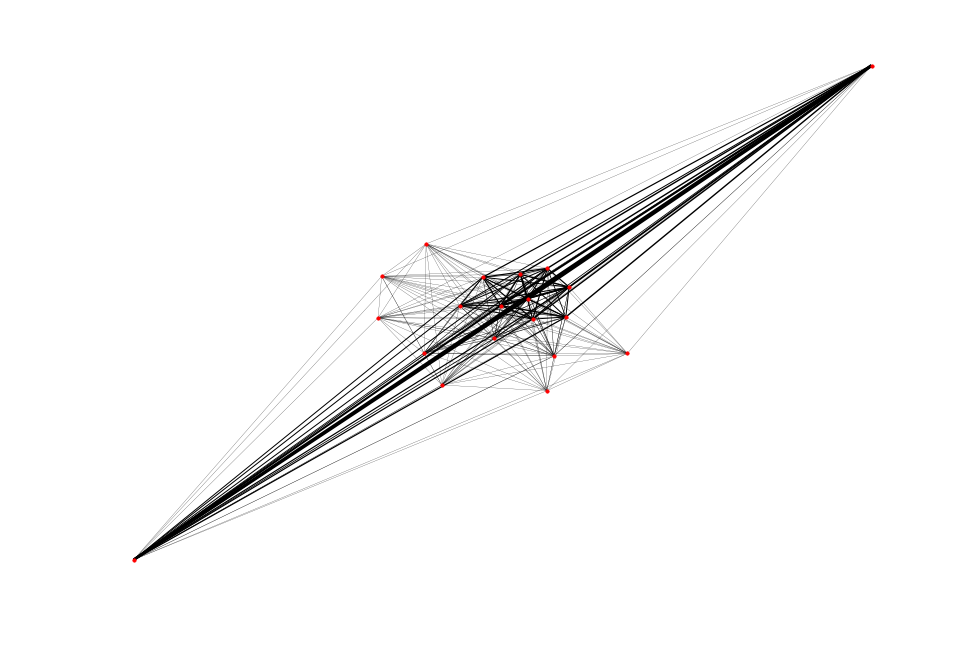

In [15]:
# choose the layout
pos = nx.spring_layout(runner_graph)

# get edge weight to use as width in the plot
edgewidth = [ d['weight'] for (u,v,d) in runner_graph.edges(data=True)]

# acutal plot
nx.draw_networkx_nodes(runner_graph, pos,node_size=3)
nx.draw_networkx_edges(runner_graph, pos, width = np.array(edgewidth)/10.0)
plt.axis('off');

# Network statistics 

## Centralities measures

In [37]:
# nx.closeness_centrality(runner_graph) # ---> all 1s !! ?????

In [82]:
# nx.betweenness_centrality(runner_graph) # ---> all 0s !! ?????

In [52]:
# nx.degree_centrality(runner_graph)  # ---> all 1s !! ?????

In [ ]:
# def my_deg_cent()

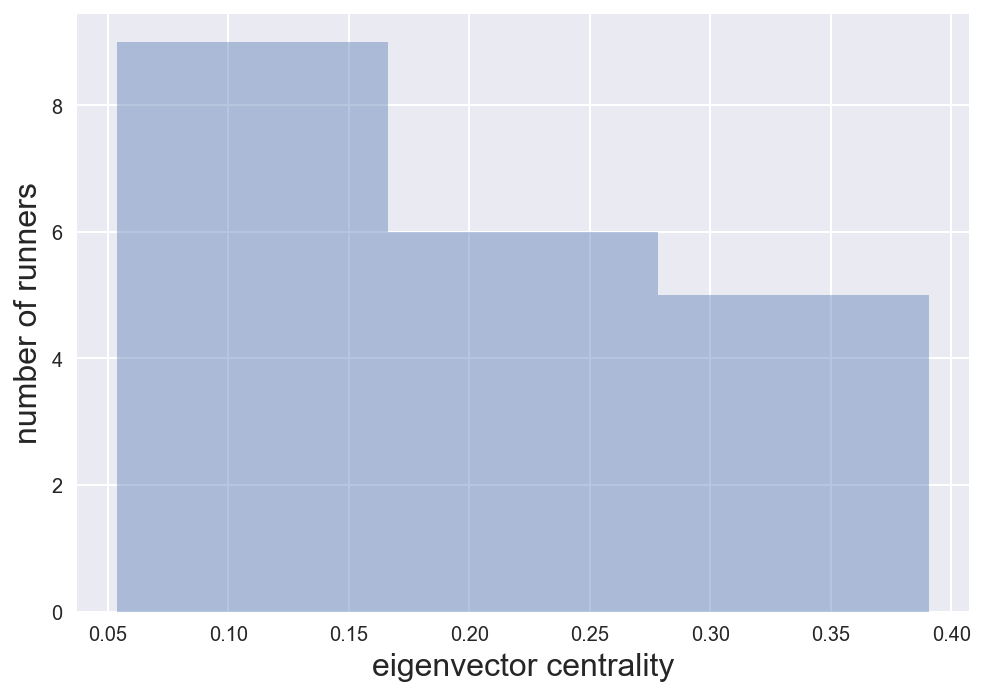

In [16]:
eigen_centr = nx.eigenvector_centrality(runner_graph)

sns.distplot(list(eigen_centr.values()),kde=False)
plt.ylabel('number of runners',size=16)
plt.xlabel('eigenvector centrality',size=16);

## Average degree connectivity

In [17]:
nx.average_degree_connectivity(runner_graph)

{19: 19.0}

## Clustering coefficient

## Community detection

In [18]:
import community

Compute the best partition:

In [19]:
?community

In [21]:
partition = community.best_partition(runner_graph)

print('number of communities:', len(set(partition.values())))

number of communities: 3


Drawing communities on graph:

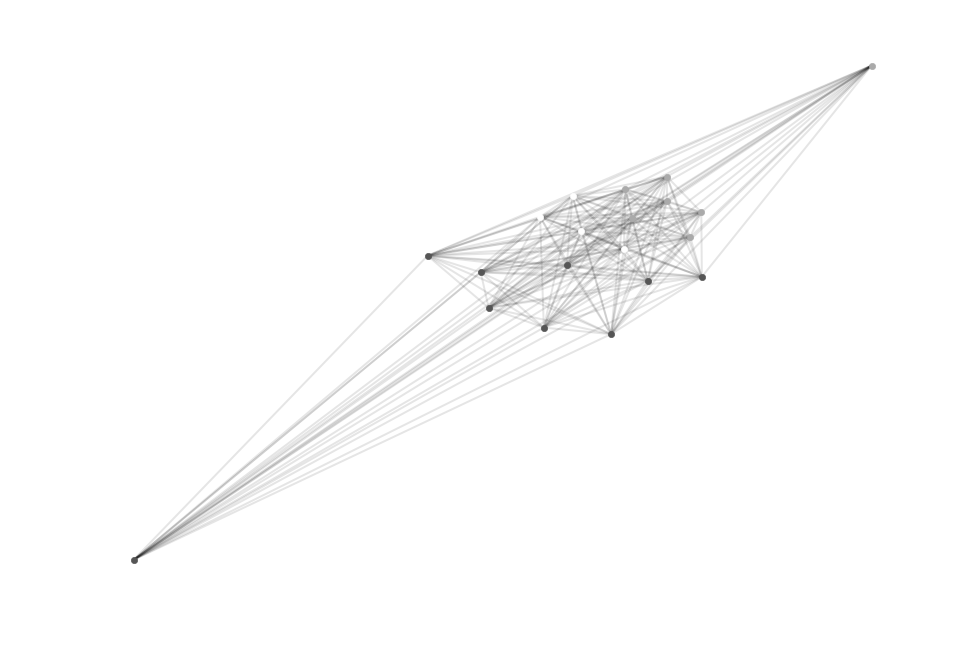

In [29]:
size = float(len(set(partition.values())))
pos = nx.spring_layout(runner_graph)

count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(runner_graph, pos, list_nodes, node_size = 10,
                                node_color = str(count / size))


nx.draw_networkx_edges(runner_graph,pos, alpha = 0.1)
plt.axis('off')
plt.show();

# code for parallelization

initialize CPUs pool:

In [61]:
import multiprocessing

pool_size  = multiprocessing.cpu_count()
pool = multiprocessing.Pool(pool_size)
print("we are using, max N thread on cpu=",pool_size) 

we are using, max N thread on cpu= 8


create global list for _shared memory_:

In [69]:
my_manager = multiprocessing.Manager()

glob_dic = my_manager.dict(nodes_dict)

running parallel computations:

In [76]:
%%time

def my_loop(c):
    
    c0_races = full_df[full_df.UserID==c[0]].RaceID.unique()
    c1_races = full_df[full_df.UserID==c[1]].RaceID.unique()
    n_shared_race = len(set(c0_races) & set(c1_races))
    
    if n_shared_race!=0:

        return [nodes_dict[c[0]],nodes_dict[c[1]],n_shared_race]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [77]:
%%time
edge_list =  pool.map(my_loop,itt.combinations(nodes_dict.keys(),2))

CPU times: user 10.3 ms, sys: 3.29 ms, total: 13.6 ms
Wall time: 3.2 s


In [115]:
# edge_list

# old code

create a dictionary for nodes' names/index:

In [53]:
dict_map = nodes_dict.copy()

for n,item in enumerate(dict_map):
    dict_map[item] = n